In [8]:
# Cell 1
%pip install ultralytics pymupdf opencv-python matplotlib pillow --quiet

import cv2
import fitz
import torch
from ultralytics import YOLO
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

print("cv2 version:", cv2.__version__)
print("PyMuPDF version:", fitz.__doc__.splitlines()[0])
print("PyTorch version:", torch.__version__)


Note: you may need to restart the kernel to use updated packages.
cv2 version: 4.12.0
PyMuPDF version: PyMuPDF 1.26.6: Python bindings for the MuPDF 1.26.11 library (rebased implementation).
PyTorch version: 2.9.1+cu128


In [9]:
# Cell 2
ROOT_DIR = Path("/home/gpuhead-1/Desktop/Makhmud/AISEC_hackathon")
DATA_DIR = ROOT_DIR / "data" / "IDP_stamp_signature_detection.v2i.yolov8"

# Load pretrained model
# Try YOLOv11 if available, else fallback to YOLOv8
model_name = "yolo11n.pt"  # change to correct filename if you have it
try:
    model = YOLO(model_name)
    print("Loaded YOLOv11 model:", model_name)
except Exception as e:
    print("YOLOv11 not found, falling back to YOLOv8s")
    model = YOLO("yolov8s.pt")

print("Classes in model:", model.names)


Loaded YOLOv11 model: yolo11n.pt
Classes in model: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'rem

In [10]:
# Cell 3 — Training config with multiple GPUs and model saving
DATA_YAML = str(DATA_DIR / "data.yaml")

EPOCHS = 50            # number of epochs
IMG_SIZE = 1024       # resolution
BATCH_SIZE = 8        # increase batch size since using multiple GPUs
DEVICES = [2, 3]      # use GPU device IDs 2 and 3

print("Training with:")
print(" data:", DATA_YAML)
print(" epochs:", EPOCHS)
print(" imgsz:", IMG_SIZE)
print(" batch_size:", BATCH_SIZE)
print(" devices:", DEVICES)

# Train the model
results = model.train(
    data=DATA_YAML,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    device=DEVICES,
    project=str(ROOT_DIR / "runs"),
    name="yolo_stamp_signature_IDP",
    exist_ok=True
)


Training with:
 data: /home/gpuhead-1/Desktop/Makhmud/AISEC_hackathon/data/IDP_stamp_signature_detection.v2i.yolov8/data.yaml
 epochs: 50
 imgsz: 1024
 batch_size: 8
 devices: [2, 3]
Ultralytics 8.3.228 🚀 Python-3.10.19 torch-2.9.1+cu128 CUDA:2 (NVIDIA GeForce RTX 4090, 24081MiB)
                                                       CUDA:3 (NVIDIA GeForce RTX 4090, 24081MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/gpuhead-1/Desktop/Makhmud/AISEC_hackathon/data/IDP_stamp_signature_detection.v2i.yolov8/data.yaml, degrees=0.0, deterministic=True, device=2,3, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_

In [15]:
# After training (Cell 3 continued)…

# Define models directory
MODELS_DIR = ROOT_DIR / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Define where the run was saved
run_dir = ROOT_DIR / "runs" / "yolo_stamp_signature_IDP"
weights_dir = run_dir / "weights"

best_pt = weights_dir / "best.pt"
last_pt = weights_dir / "last.pt"

if best_pt.exists():
    chosen = best_pt
    print("Using best.pt:", chosen)
elif last_pt.exists():
    chosen = last_pt
    print("best.pt not found, using last.pt:", chosen)
else:
    raise FileNotFoundError(f"No weights found in {weights_dir}")

# Determine version from model name
model_name_str = model.model_name if hasattr(model, 'model_name') else model.cfg if hasattr(model, 'cfg') else ""
# Fallback: you could explicitly set a variable at model-load time, e.g. MODEL_VERSION = "yolo11"
#
if "yolo11" in model_name_str.lower():
    version_tag = "yolo11"
elif "yolov8" in model_name_str.lower():
    version_tag = "yolov8"
else:
    version_tag = "custom"

# Compose custom name
custom_name = MODELS_DIR / f"best_{version_tag}_stamp_signature_IDP.pt"

import shutil
shutil.copy(str(chosen), str(custom_name))
print("Model weights copied and renamed to:", custom_name)


Using best.pt: /home/gpuhead-1/Desktop/Makhmud/AISEC_hackathon/runs/yolo_stamp_signature_IDP/weights/best.pt
Model weights copied and renamed to: /home/gpuhead-1/Desktop/Makhmud/AISEC_hackathon/models/best_yolo11_stamp_signature_IDP.pt


In [12]:
# Cell: Inspect columns
import pandas as pd
from pathlib import Path

run_dir = Path("/home/gpuhead-1/Desktop/Makhmud/AISEC_hackathon/runs/yolo_stamp_signature_IDP")
results_csv = run_dir / "results.csv"
df = pd.read_csv(results_csv)

print("Columns in results.csv:")
print(df.columns.tolist())


Columns in results.csv:
['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


Columns in results.csv: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


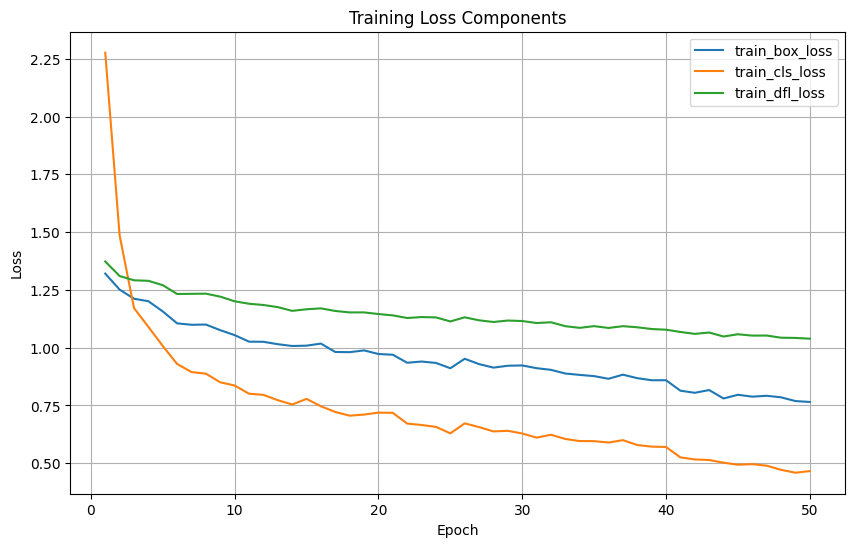

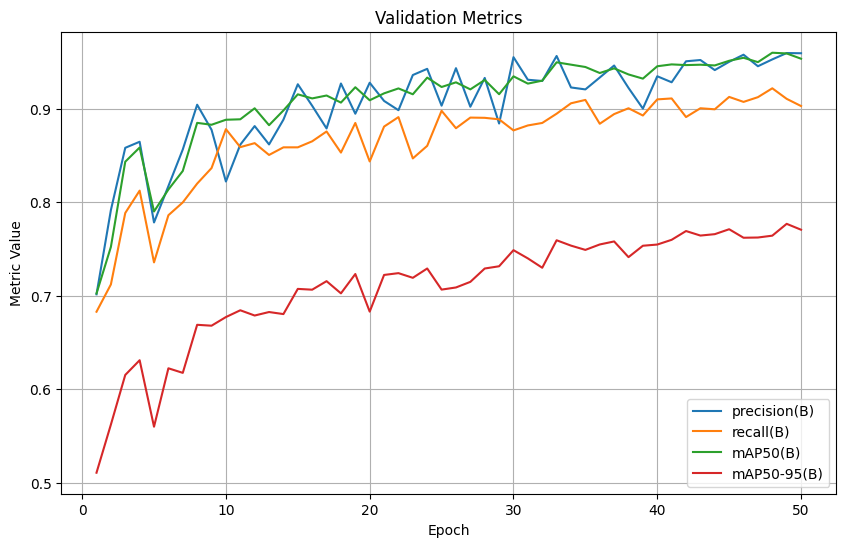

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

run_dir = Path("/home/gpuhead-1/Desktop/Makhmud/AISEC_hackathon/runs/yolo_stamp_signature_IDP")
results_csv = run_dir / "results.csv"
df = pd.read_csv(results_csv)

print("Columns in results.csv:", df.columns.tolist())

# --- Plot A: Losses ---
plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['train/box_loss'], label='train_box_loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='train_cls_loss')
plt.plot(df['epoch'], df['train/dfl_loss'], label='train_dfl_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Components')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot B: Metrics ---
plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['metrics/precision(B)'], label='precision(B)')
plt.plot(df['epoch'], df['metrics/recall(B)'], label='recall(B)')
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50(B)')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95(B)')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Validation Metrics')
plt.legend()
plt.grid(True)
plt.show()
